In [3]:
# 🔧 Imports et configuration
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import random
from PIL import Image
import re
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

# Style dark theme
plt.style.use('dark_background')
sns.set_palette("husl")

# Seeds pour reproductibilité
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# 🎯 HYPERPARAMETERS - Recipe Image Retrieval avec EfficientNet
CONFIG = {
    # === IMAGE PARAMETERS ===
    'IMG_SIZE': 224,                    # ✅ Optimal pour EfficientNet
    'BATCH_SIZE': 32,                   # ✅ Bon équilibre mémoire/performance
    
    # === EMBEDDING PARAMETERS ===
    'EMBEDDING_DIM_NATIVE': 1280,       # 🆕 EfficientNet features natives
    'EMBEDDING_DIM_CUSTOM': 512,        # 🆕 Custom head output (si fine-tuning)
    
    # === PHASE 1: FEATURE EXTRACTION ===
    'USE_NATIVE_FEATURES': True,        # 🆕 True = 1280-dim, False = 512-dim custom
    
    # === PHASE 2: TRANSFER LEARNING ===
    'TRANSFER_EPOCHS': 15,              # 🆕 Entraînement head seulement
    'TRANSFER_LR': 0.001,               # 🆕 Learning rate plus élevé pour nouvelles couches
    'TRANSFER_BATCH_SIZE': 32,          # 🆕 Plus petit pour stabilité
    
    # === PHASE 3: FINE-TUNING ===
    'FINETUNE_EPOCHS': 20,              # 🆕 Fine-tuning complet
    'FINETUNE_LR': 0.0001,              # ✅ Learning rate faible pour pré-entraîné
    'FINETUNE_UNFREEZE_LAYERS': 20,     # 🆕 Nombre de couches à dégeler
    
    # === TRAINING PARAMETERS ===
    'TRIPLET_MARGIN': 0.3,              # 🔄 Augmenté pour meilleure séparation
    'DROPOUT_RATE': 0.3,                # ✅ Régularisation
    'WEIGHT_DECAY': 0.0001,             # 🆕 L2 regularization
    
    # === OPTIMIZATION ===
    'OPTIMIZER': 'adam',                # ✅ Standard
    'PATIENCE': 5,                      # 🆕 Early stopping
    'REDUCE_LR_PATIENCE': 3,            # 🆕 Réduction LR
    'REDUCE_LR_FACTOR': 0.5,            # 🆕 Facteur réduction
    
    # === DATA AUGMENTATION ===
    'USE_AUGMENTATION': True,           # 🆕 Pour fine-tuning
    'ROTATION_RANGE': 15,               # 🆕 Rotation aléatoire
    'ZOOM_RANGE': 0.1,                  # 🆕 Zoom aléatoire
    'HORIZONTAL_FLIP': True,            # 🆕 Flip horizontal
    
    # === EVALUATION ===
    'SIMILARITY_THRESHOLD': 0.7,       # 🆕 Seuil similarité
    'TOP_K_RESULTS': 3,                 # ✅ Nombre résultats retournés
    'VALIDATION_SPLIT': 0.2,           # 🆕 Split pour validation
}

# 🎯 HYPERPARAMÈTRES Transfer Learning
CONFIG_TL = {
    # === IMAGE PARAMETERS ===
    'IMG_SIZE': 224,                    # ✅ Optimal pour EfficientNet
    'BATCH_SIZE': 32,                   # ✅ Bon équilibre mémoire/performance
    
    # === EMBEDDING PARAMETERS ===
    'EMBEDDING_DIM_NATIVE': 1280,       # 🆕 EfficientNet features natives
    'EMBEDDING_DIM_CUSTOM': 512,        # 🆕 Custom head output
    
    # === TRANSFER LEARNING (TRIPLET) ===
    'TRANSFER_EPOCHS': 15,              # 🆕 Entraînement avec triplet loss
    'TRANSFER_LR': 0.001,               # 🆕 Learning rate pour nouvelles couches
    'TRIPLET_MARGIN': 0.3,              # 🎯 Marge triplet loss
    'DROPOUT_RATE': 0.3,                # ✅ Régularisation
    'WEIGHT_DECAY': 0.0001,             # 🆕 L2 regularization
    
    # === OPTIMIZATION AVANCÉE ===
    'OPTIMIZER': 'adam',                # ✅ Standard
    'PATIENCE': 3,                      # 🆕 Early stopping
    'REDUCE_LR_PATIENCE': 2,            # 🆕 Réduction LR
    'REDUCE_LR_FACTOR': 0.5,            # 🆕 Facteur réduction
    'MIN_LR': 1e-7,                     # 🆕 LR minimum
    
    # === DATA AUGMENTATION ===
    'USE_AUGMENTATION': True,           # 🆕 Augmentation
    'ROTATION_RANGE': 15,               # 🆕 Rotation aléatoire
    'ZOOM_RANGE': 0.1,                  # 🆕 Zoom aléatoire
    'BRIGHTNESS_RANGE': [0.9, 1.1],     # 🆕 Luminosité
    'HORIZONTAL_FLIP': True,            # 🆕 Flip horizontal
    
    # === VALIDATION & ÉVALUATION ===
    'VALIDATION_SPLIT': 0.2,           # 🆕 Split pour validation
    'TOP_K_RESULTS': 3,                 # ✅ Nombre résultats
    'MIN_IMAGES_PER_RECIPE': 1,         # 🆕 Filtrage minimum
    'MAX_PAIRS_PER_RECIPE': 5,          # 🆕 Limite paires par recette
    
    # === MODÈLE ===
    'MODEL_NAME': 'recipe_image_retrieval_model_tl.keras',
    'EMBEDDINGS_NAME': 'recipe_embeddings_database_tl.npy',
    'METADATA_NAME': 'recipe_embeddings_database_metadata_tl.pkl'
}

print("🎯 Configuration adaptée pour EfficientNet Transfer Learning")
print(f"📊 Phase 2: Transfer learning ({CONFIG['EMBEDDING_DIM_CUSTOM']}-dim, {CONFIG['TRANSFER_EPOCHS']} epochs)")

print("✅ Imports et configuration OK!")
print(f"🔥 TensorFlow: {tf.__version__}")
print(f"🖥️ GPU: {tf.config.list_physical_devices('GPU')}")


🎯 Configuration adaptée pour EfficientNet Transfer Learning
📊 Phase 2: Transfer learning (512-dim, 15 epochs)
✅ Imports et configuration OK!
🔥 TensorFlow: 2.19.0
🖥️ GPU: []


In [ ]:
# 🚀 TRANSFER LEARNING - Triplet Loss + EfficientNetB0
# ================================================================================
# ✅ Triplet Loss (meilleur que Contrastive)
# ✅ Architecture robuste + gestion d'erreurs  
# ✅ Hyperparamètres avancés (weight decay, reduce LR, validation)
# ✅ Configuration moderne avec callbacks

import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print(f"🚀 Configuration Transfer Learning Ultime:")
print(f"   📐 Image Size: {CONFIG_TL['IMG_SIZE']}x{CONFIG_TL['IMG_SIZE']}")
print(f"   📦 Batch Size: {CONFIG_TL['BATCH_SIZE']}")
print(f"   🔄 Max Epochs: {CONFIG_TL['TRANSFER_EPOCHS']}")
print(f"   🧠 Embedding Dim: {CONFIG_TL['EMBEDDING_DIM_CUSTOM']} (custom)")
print(f"   📈 Learning Rate: {CONFIG_TL['TRANSFER_LR']}")
print(f"   🎯 Triplet Margin: {CONFIG_TL['TRIPLET_MARGIN']}")
print(f"   🔄 Dropout Rate: {CONFIG_TL['DROPOUT_RATE']}")
print(f"   ⚖️ Weight Decay: {CONFIG_TL['WEIGHT_DECAY']}")
print(f"   ⏰ Early Stopping: {CONFIG_TL['PATIENCE']} epochs")

# 🖼️ PREPROCESSING
def preprocess_image(image_path, img_size=224):
    """Preprocessing robuste avec gestion d'erreurs complète + EfficientNet optimisé"""
    try:
        if not os.path.exists(image_path):
            return None
        
        # Vérifier la taille du fichier (éviter fichiers corrompus)
        if os.path.getsize(image_path) < 1024:  # Moins de 1KB
            return None
        
        img = Image.open(image_path)
        
        # Vérifier si l'image est valide
        img.verify()
        img = Image.open(image_path)  # Recharger après verify
        
        # Convertir en RGB si nécessaire
        if img.mode != 'RGB':
            img = img.convert('RGB')
        
        # Redimensionner avec qualité optimale
        img = img.resize((img_size, img_size), Image.Resampling.LANCZOS)
        
        # Convertir en array et appliquer preprocessing EfficientNet
        img_array = np.array(img, dtype=np.float32)
        img_array = preprocess_input(img_array)  # ✅ Normalisation EfficientNet native
        
        return img_array
        
    except Exception as e:
        # print(f"❌ Erreur traitement {image_path}: {e}")  # Optionnel pour debug
        return None
    
# 🎯 COUCHE L2 NORMALIZATION PERSONNALISÉE (SÉRIALISABLE)
class L2NormalizationLayer(Layer):
    """Couche personnalisée pour normalisation L2 - sérialisable"""
    
    def __init__(self, axis=1, **kwargs):
        super(L2NormalizationLayer, self).__init__(**kwargs)
        self.axis = axis
    
    def call(self, inputs):
        return tf.nn.l2_normalize(inputs, axis=self.axis)
    
    def compute_output_shape(self, input_shape):
        return input_shape
    
    def get_config(self):
        config = super(L2NormalizationLayer, self).get_config()
        config.update({'axis': self.axis})
        return config

# 🎯 COUCHE EXTRACTION TRIPLET PERSONNALISÉE (SÉRIALISABLE)
class ExtractTripletComponent(Layer):
    """Couche pour extraire une composante du triplet"""
    
    def __init__(self, component_index, **kwargs):
        super(ExtractTripletComponent, self).__init__(**kwargs)
        self.component_index = component_index
    
    def call(self, inputs):
        return inputs[:, self.component_index]
    
    def compute_output_shape(self, input_shape):
        # input_shape = (batch_size, 3, height, width, channels)
        return (input_shape[0], input_shape[2], input_shape[3], input_shape[4])
    
    def get_config(self):
        config = super(ExtractTripletComponent, self).get_config()
        config.update({'component_index': self.component_index})
        return config

# 🎯 COUCHE STACK TRIPLET PERSONNALISÉE (SÉRIALISABLE)
class TripletStackLayer(Layer):
    """Couche personnalisée pour empiler les embeddings triplet"""
    
    def __init__(self, **kwargs):
        super(TripletStackLayer, self).__init__(**kwargs)
    
    def call(self, inputs):
        # inputs = [anchor_emb, positive_emb, negative_emb]
        return tf.stack(inputs, axis=1)
    
    def compute_output_shape(self, input_shape):
        # input_shape = [(batch_size, embedding_dim), ...]
        batch_size = input_shape[0][0]
        embedding_dim = input_shape[0][1]
        return (batch_size, 3, embedding_dim)
    
    def get_config(self):
        return super(TripletStackLayer, self).get_config()

# 🏗️ ARCHITECTURE EMBEDDING
def create_embedding_model(input_shape=(224, 224, 3), embedding_dim=512):
    """Modèle d'embedding avec architecture optimisée pour triplet loss"""
    
    # EfficientNetB0 pré-entraîné (backbone gelé)
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    base_model.trainable = False  # Geler le backbone initialement
    
    # Tête personnalisée optimisée
    x = base_model.output
    x = GlobalAveragePooling2D(name='global_avg_pool')(x)
    
    # Première couche dense avec plus de neurones
    x = Dense(1024, activation='relu', name='dense_1024')(x)
    x = Dropout(CONFIG_TL['DROPOUT_RATE'], name='dropout_1')(x)
    
    # Deuxième couche dense intermédiaire commentée pour entrainer plus vite
    # x = Dense(embedding_dim * 2, activation='relu', name='dense_1024_2')(x)
    # x = Dropout(CONFIG_TL['DROPOUT_RATE'] * 0.5, name='dropout_2')(x)
    
    # Couche d'embedding finale (sans activation)
    embeddings = Dense(embedding_dim, activation=None, name='embeddings')(x)


    # ✅ Normalisation L2 OBLIGATOIRE pour triplet loss + similarité cosinus
    embeddings_normalized = L2NormalizationLayer(axis=1, name='l2_norm')(embeddings)
    
    model = Model(inputs=base_model.input, outputs=embeddings_normalized, name='TransferLearningEmbeddingModel')
    
    print(f"✅ Modèle d'embedding créé:")
    print(f"   📊 Params totaux: {model.count_params():,}")
    print(f"   🔥 Params entraînables: {sum([tf.size(w) for w in model.trainable_weights]):,}")
    print(f"   🎯 Architecture: EfficientNetB0 + Custom Head ({embedding_dim}D)")
    
    return model

# 🎯 TRIPLET LOSS OPTIMISÉE POUR EMBEDDINGS NORMALISÉS
def triplet_loss(margin=0.3):
    """Triplet loss optimisée pour embeddings L2-normalisés"""
    def triplet_loss_fn(y_true, y_pred):
        """
        y_pred contient [anchor, positive, negative] embeddings normalisés
        Utilise distance cosinus (1 - similarity) pour la loss
        """
        anchor = y_pred[:, 0, :]      # (batch_size, embedding_dim)
        positive = y_pred[:, 1, :]    # (batch_size, embedding_dim)
        negative = y_pred[:, 2, :]    # (batch_size, embedding_dim)
        
        # Calcul des distances cosinus (1 - similarité cosinus)
        # Pour embeddings normalisés: cosine_sim = dot_product
        pos_similarity = tf.reduce_sum(anchor * positive, axis=1)
        neg_similarity = tf.reduce_sum(anchor * negative, axis=1)
        
        pos_distance = 1.0 - pos_similarity
        neg_distance = 1.0 - neg_similarity
        
        # Triplet loss: max(0, pos_dist - neg_dist + margin)
        basic_loss = pos_distance - neg_distance + margin
        loss = tf.maximum(0.0, basic_loss)
        
        return tf.reduce_mean(loss)
    
    return triplet_loss_fn

# 📊 GÉNÉRATEUR DE TRIPLETS
class TripletGenerator(tf.keras.utils.Sequence):
    """Générateur de triplets avec validation et augmentation avancée"""
    
    def __init__(self, recipes_df, batch_size=32, img_size=224, augment=True, validation_split=0.2, is_validation=False):
        self.batch_size = batch_size
        self.img_size = img_size
        self.augment = augment and not is_validation
        self.is_validation = is_validation
        
        # Filtrer et diviser les données
        self.valid_recipes = self._filter_valid_recipes(recipes_df)
        self.train_recipes, self.val_recipes = self._split_data(validation_split)
        
        # Utiliser le bon subset
        self.recipes_df = self.val_recipes if is_validation else self.train_recipes
        
        # Grouper par recette
        self.recipe_groups = self.recipes_df.groupby('Title')
        self.recipe_names = list(self.recipe_groups.groups.keys())
        
        # Configuration augmentation
        if self.augment:
            self.datagen = ImageDataGenerator(
                rotation_range=CONFIG_TL['ROTATION_RANGE'],
                width_shift_range=0.1,
                height_shift_range=0.1,
                horizontal_flip=CONFIG_TL['HORIZONTAL_FLIP'],
                zoom_range=CONFIG_TL['ZOOM_RANGE'],
                brightness_range=CONFIG_TL['BRIGHTNESS_RANGE'],
                fill_mode='nearest'
            )
        
        self.on_epoch_end()
        
        split_name = "Validation" if is_validation else "Entraînement"
        print(f"✅ Générateur {split_name} créé:")
        print(f"   📊 Recettes: {len(self.recipe_names)}")
        print(f"   📸 Images: {len(self.recipes_df)}")
        print(f"   🔄 Augmentation: {'Activée' if self.augment else 'Désactivée'}")
    
    def _filter_valid_recipes(self, recipes_df):
        """Filtrer les recettes avec images valides"""
        valid_recipes = []
        
        print("🔍 Filtrage des images valides...")
        for idx, row in tqdm(recipes_df.iterrows(), total=len(recipes_df), desc="Validation images"):
            if pd.notna(row['image_path']) and os.path.exists(row['image_path']):
                # Test de chargement rapide
                try:
                    img = Image.open(row['image_path'])
                    img.verify()
                    valid_recipes.append(row)
                except:
                    continue
        
        result_df = pd.DataFrame(valid_recipes)
        print(f"✅ {len(result_df)}/{len(recipes_df)} images valides")
        return result_df
    
    def _split_data(self, validation_split):
        """Diviser les données en train/validation par recette"""
        unique_recipes = self.valid_recipes['Title'].unique()
        
        train_recipes, val_recipes = train_test_split(
            unique_recipes, 
            test_size=validation_split, 
            random_state=42
        )
        
        train_df = self.valid_recipes[self.valid_recipes['Title'].isin(train_recipes)]
        val_df = self.valid_recipes[self.valid_recipes['Title'].isin(val_recipes)]
        
        return train_df, val_df
    
    def __len__(self):
        return max(1, len(self.recipes_df) // self.batch_size)
    
    def __getitem__(self, index):
        return self._generate_triplet_batch()
    
    def on_epoch_end(self):
        """Mélanger les données à chaque époque"""
        pass
    
    def _generate_triplet_batch(self):
        """Générer un batch de triplets avec gestion robuste des erreurs"""
        batch_size = self.batch_size
        
        anchors = np.zeros((batch_size, self.img_size, self.img_size, 3), dtype=np.float32)
        positives = np.zeros((batch_size, self.img_size, self.img_size, 3), dtype=np.float32)
        negatives = np.zeros((batch_size, self.img_size, self.img_size, 3), dtype=np.float32)
        
        valid_triplets = 0
        attempts = 0
        max_attempts = batch_size * 5  # Plus de tentatives pour robustesse
        
        while valid_triplets < batch_size and attempts < max_attempts:
            attempts += 1
            
            try:
                # Sélectionner une recette positive (avec au moins 1 image)
                pos_recipe = np.random.choice(self.recipe_names)
                pos_group = self.recipe_groups.get_group(pos_recipe)
                
                # Sélectionner une recette négative différente
                available_neg_recipes = [r for r in self.recipe_names if r != pos_recipe]
                if not available_neg_recipes:
                    continue
                    
                neg_recipe = np.random.choice(available_neg_recipes)
                neg_group = self.recipe_groups.get_group(neg_recipe)
                
                # Sélectionner les images du triplet
                if len(pos_group) >= 2:
                    # Cas idéal: 2 images différentes de la même recette
                    anchor_row, pos_row = pos_group.sample(2).iloc
                else:
                    # Cas limite: même image pour anchor et positive
                    anchor_row = pos_row = pos_group.iloc[0]
                
                # Image négative d'une recette différente
                neg_row = neg_group.sample(1).iloc[0]
                
                # Charger et préprocesser les images
                anchor_img = preprocess_image(anchor_row['image_path'], self.img_size)
                pos_img = preprocess_image(pos_row['image_path'], self.img_size)
                neg_img = preprocess_image(neg_row['image_path'], self.img_size)
                
                # Vérifier que toutes les images sont valides
                if anchor_img is not None and pos_img is not None and neg_img is not None:
                    
                    # Appliquer l'augmentation de données
                    if self.augment:
                        anchor_img = self.datagen.random_transform(anchor_img)
                        pos_img = self.datagen.random_transform(pos_img)
                        # Pas d'augmentation sur negative pour plus de diversité
                    
                    # Ajouter au batch
                    anchors[valid_triplets] = anchor_img
                    positives[valid_triplets] = pos_img
                    negatives[valid_triplets] = neg_img
                    
                    valid_triplets += 1
                    
            except Exception as e:
                # Continuer en cas d'erreur sur un triplet
                continue
        
        # Compléter avec des copies si nécessaire (cas rare)
        while valid_triplets < batch_size:
            copy_idx = np.random.randint(0, max(1, valid_triplets))
            anchors[valid_triplets] = anchors[copy_idx]
            positives[valid_triplets] = positives[copy_idx]  
            negatives[valid_triplets] = negatives[copy_idx]
            valid_triplets += 1
        
        # Format pour le modèle triplet: (batch_size, 3, height, width, channels)
        triplet_batch = np.stack([anchors, positives, negatives], axis=1)
        dummy_labels = np.zeros((batch_size, 1))  # Non utilisé avec triplet loss
        
        return triplet_batch, dummy_labels

# 🏗️ MODÈLE TRIPLET POUR ENTRAÎNEMENT
def create_triplet_model(embedding_model):
   
    """Modèle triplet avec couches personnalisées sérialisables"""

    # Input: batch de triplets (batch_size, 3, height, width, channels)
    triplet_input = tf.keras.layers.Input(
        shape=(3, CONFIG_TL['IMG_SIZE'], CONFIG_TL['IMG_SIZE'], 3),
        name='triplet_input'
    )
    
    # ✅ CORRECTION : Utiliser les couches personnalisées sérialisables
    anchor = ExtractTripletComponent(0, name='extract_anchor')(triplet_input)
    positive = ExtractTripletComponent(1, name='extract_positive')(triplet_input)
    negative = ExtractTripletComponent(2, name='extract_negative')(triplet_input)
    
    # Obtenir les embeddings normalisés
    anchor_emb = embedding_model(anchor)
    positive_emb = embedding_model(positive)
    negative_emb = embedding_model(negative)
    
    # ✅ CORRECTION : Utiliser la couche personnalisée pour stack
    triplet_output = TripletStackLayer(name='combine_embeddings')([anchor_emb, positive_emb, negative_emb])
    
    model = Model(inputs=triplet_input, outputs=triplet_output, name='TransferLearningTripletModel')
    
    print(f"✅ Modèle triplet créé:")
    print(f"   📊 Input shape: {model.input_shape}")
    print(f"   📊 Output shape: {model.output_shape}")
    
    return model

# 📊 MÉTRIQUES PERSONNALISÉES AVANCÉES
def triplet_accuracy(y_true, y_pred):
    """Précision: % de triplets où positive plus proche que negative"""
    anchor = y_pred[:, 0, :]     # (batch_size, embedding_dim)
    positive = y_pred[:, 1, :]   # (batch_size, embedding_dim)
    negative = y_pred[:, 2, :]   # (batch_size, embedding_dim)
    
    # Similarités cosinus (plus élevé = plus similaire)
    pos_similarity = tf.reduce_sum(anchor * positive, axis=1)
    neg_similarity = tf.reduce_sum(anchor * negative, axis=1)
    
    # Triplet correct si positive plus similaire que negative
    correct_triplets = tf.cast(pos_similarity > neg_similarity, tf.float32)
    accuracy = tf.reduce_mean(correct_triplets)
    
    return accuracy

def average_positive_similarity(y_true, y_pred):
    """Similarité moyenne anchor-positive"""
    anchor = y_pred[:, 0, :]
    positive = y_pred[:, 1, :]
    pos_similarity = tf.reduce_sum(anchor * positive, axis=1)
    return tf.reduce_mean(pos_similarity)

def average_negative_similarity(y_true, y_pred):
    """Similarité moyenne anchor-negative"""
    anchor = y_pred[:, 0, :]
    negative = y_pred[:, 2, :]
    neg_similarity = tf.reduce_sum(anchor * negative, axis=1)
    return tf.reduce_mean(neg_similarity)

# 🚀 FONCTION D'ENTRAÎNEMENT PRINCIPALE
def train_transfer_learning():
    """Entraînement complet avec toutes les optimisations"""
    
    print("🚀 Début de l'entraînement Transfer Learning Ultime...")
    print("=" * 60)
    
    # Charger les données
    try:
        recipes_df = pd.read_pickle("./data/recipes_with_images_dataframe.pkl")
        print(f"✅ {len(recipes_df)} recettes chargées depuis le DataFrame")
    except FileNotFoundError:
        print("❌ Fichier recipes_with_images_dataframe.pkl non trouvé")
        print("   Assurez-vous d'avoir exécuté le notebook raw qui génère le DataFrame sous forme de pickle")
        return None, None
    
    # Créer le modèle d'embedding
    print("\n🏗️ Création du modèle d'embedding...")
    embedding_model = create_embedding_model(
        input_shape=(CONFIG_TL['IMG_SIZE'], CONFIG_TL['IMG_SIZE'], 3),
        embedding_dim=CONFIG_TL['EMBEDDING_DIM_CUSTOM']
    )
    
    # Créer les générateurs de données (train + validation)
    print("\n📊 Création des générateurs de données...")
    train_generator = TripletGenerator(
        recipes_df,
        batch_size=CONFIG_TL['BATCH_SIZE'],
        img_size=CONFIG_TL['IMG_SIZE'],
        augment=CONFIG_TL['USE_AUGMENTATION'],
        validation_split=CONFIG_TL['VALIDATION_SPLIT'],
        is_validation=False
    )
    
    val_generator = TripletGenerator(
        recipes_df,
        batch_size=CONFIG_TL['BATCH_SIZE'],
        img_size=CONFIG_TL['IMG_SIZE'],
        augment=False,  # Pas d'augmentation en validation
        validation_split=CONFIG_TL['VALIDATION_SPLIT'],
        is_validation=True
    )
    
    # Créer le modèle triplet
    print("\n🎯 Création du modèle triplet...")
    triplet_model = create_triplet_model(embedding_model)
    
    # Compiler le modèle avec optimisations
    print("\n🔧 Compilation du modèle...")
    triplet_model.compile(
        optimizer=Adam(
            learning_rate=CONFIG_TL['TRANSFER_LR'],
            weight_decay=CONFIG_TL['WEIGHT_DECAY']  # L2 regularization
        ),
        loss=triplet_loss(margin=CONFIG_TL['TRIPLET_MARGIN']),
        metrics=[triplet_accuracy, average_positive_similarity, average_negative_similarity]
    )
    
    print(f"✅ Modèle compilé:")
    print(f"   📈 Optimizer: Adam (lr={CONFIG_TL['TRANSFER_LR']}, wd={CONFIG_TL['WEIGHT_DECAY']})")
    print(f"   📉 Loss: Triplet Loss (margin={CONFIG_TL['TRIPLET_MARGIN']})")
    print(f"   📊 Métriques: Accuracy + Similarités moyenne")

    # ✅ CALLBACK PERSONNALISÉ pour sauvegarder UNIQUEMENT l'embedding model
    class EmbeddingModelCheckpoint(tf.keras.callbacks.Callback):
        """
        Callback personnalisé qui sauvegarde l'embedding model (pas le triplet model)
        C'est CRUCIAL car ModelCheckpoint standard sauvegarderait le triplet model !
        """
        def __init__(self, embedding_model, filepath, monitor='val_loss', save_best_only=True, verbose=1):
            super().__init__()
            self.embedding_model = embedding_model  # 🎯 Le modèle qui nous intéresse
            self.filepath = filepath
            self.monitor = monitor
            self.save_best_only = save_best_only
            self.verbose = verbose
            self.best_value = np.inf if 'loss' in monitor else -np.inf
            
        def on_epoch_end(self, epoch, logs=None):
            current_value = logs.get(self.monitor)
            if current_value is None:
                if self.verbose > 0:
                    print(f"\n⚠️ Métrique '{self.monitor}' non trouvée dans les logs")
                return
                
            improved = False
            if 'loss' in self.monitor or 'error' in self.monitor:
                # Pour les métriques à minimiser
                if current_value < self.best_value:
                    self.best_value = current_value
                    improved = True
            else:
                # Pour les métriques à maximiser (accuracy, etc.)
                if current_value > self.best_value:
                    self.best_value = current_value
                    improved = True
                    
            if improved or not self.save_best_only:
                try:
                    # 🎯 SAUVEGARDER L'EMBEDDING MODEL (pas le triplet model)
                    self.embedding_model.save(self.filepath)
                    
                    if self.verbose > 0:
                        if improved:
                            print(f"\n💾 🏆 NOUVEAU MEILLEUR EMBEDDING MODEL sauvegardé!")
                            print(f"   📁 Fichier: {self.filepath}")
                            print(f"   📊 {self.monitor}: {current_value:.4f} (précédent: {self.best_value:.4f})")
                        else:
                            print(f"\n💾 Embedding model sauvegardé: {self.filepath}")
                            
                except Exception as e:
                    if self.verbose > 0:
                        print(f"\n❌ Erreur sauvegarde embedding model: {e}")
                        
        def on_train_end(self, logs=None):
            if self.verbose > 0:
                print(f"\n✅ Entraînement terminé. Meilleur {self.monitor}: {self.best_value:.4f}")
                print(f"💾 Meilleur embedding model disponible: {self.filepath}")
    
    # Callbacks avancés
    print("\n⚙️ Configuration des callbacks...")
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=CONFIG_TL['PATIENCE'],
            restore_best_weights=True,
            verbose=1,
            mode='min'
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            patience=CONFIG_TL['REDUCE_LR_PATIENCE'],
            factor=CONFIG_TL['REDUCE_LR_FACTOR'],
            min_lr=CONFIG_TL['MIN_LR'],
            verbose=1,
            mode='min'
        ),
        ModelCheckpoint(
            f"./tl/best_triplet_{CONFIG_TL['MODEL_NAME']}",
            monitor='val_loss',
            save_best_only=True,
            save_weights_only=False,
            verbose=1,
            mode='min'
        ),
        EmbeddingModelCheckpoint(
            embedding_model,
            f"./tl/best_embedding_{CONFIG_TL['MODEL_NAME']}",
            monitor='val_loss',
            save_best_only=True,
            verbose=1,
        ),
        TensorBoard(
            log_dir=f"./tl/logs/{CONFIG_TL['MODEL_NAME']}",
            histogram_freq=1,
            write_graph=True,
            write_images=True,
            update_freq='epoch',
            profile_batch=2,
            embeddings_freq=1
        )
    ]
    
    print(f"✅ Callbacks configurés:")
    print(f"   ⏰ Early Stopping: patience={CONFIG_TL['PATIENCE']} (val_loss)")
    print(f"   📉 Reduce LR: patience={CONFIG_TL['REDUCE_LR_PATIENCE']}, factor={CONFIG_TL['REDUCE_LR_FACTOR']}")
    print(f"   💾 Model Checkpoint: best_{CONFIG_TL['MODEL_NAME']}")
    
    # Entraînement
    print("\n" + "="*60)
    print("🏋️ DÉBUT DE L'ENTRAÎNEMENT")
    print("="*60)
    print(f"📊 Entraînement: {len(train_generator)} batches/époque")
    print(f"📊 Validation: {len(val_generator)} batches/époque")
    print(f"🎯 Objectif: Apprendre des embeddings discriminants via triplet loss")
    
    start_time = time.time()
    
    history = triplet_model.fit(
        train_generator,
        epochs=CONFIG_TL['TRANSFER_EPOCHS'],
        validation_data=val_generator,
        callbacks=callbacks,
        verbose=1
    )
    
    training_time = time.time() - start_time
    
    # Sauvegarder le modèle d'embedding final
    print("\n💾 Sauvegarde du modèle...")
    embedding_model.save(f"./tl/embeddings_{CONFIG_TL['MODEL_NAME']}")
    
    # Afficher les résultats
    print("\n" + "="*60)
    print("✅ ENTRAÎNEMENT TERMINÉ AVEC SUCCÈS!")
    print("="*60)
    print(f"⏱️ Temps total: {training_time/60:.1f} minutes")
    print(f"🎯 Meilleure val_loss: {min(history.history['val_loss']):.4f}")
    print(f"📊 Précision finale: {history.history['val_triplet_accuracy'][-1]:.4f}")
    print(f"📈 Similarité pos finale: {history.history['val_average_positive_similarity'][-1]:.4f}")
    print(f"📉 Similarité neg finale: {history.history['val_average_negative_similarity'][-1]:.4f}")
    print(f"💾 Modèle sauvegardé: {CONFIG_TL['MODEL_NAME']}")
    
    return embedding_model, history

# 📈 VISUALISATION DES RÉSULTATS
def plot_training_results(history):
    """Afficher les métriques d'entraînement"""
    
    # Configuration dark mode
    plt.style.use('dark_background')
    
    # Couleurs modernes pour dark mode
    colors = {
        'primary': '#00D4AA',      # Cyan-vert brillant
        'secondary': '#FF6B6B',    # Rouge-coral moderne
        'accent': '#4ECDC4',       # Turquoise
        'warning': '#FFE66D',      # Jaune moderne
        'info': '#A8E6CF',         # Vert pastel
        'purple': '#B19CD9'        # Violet pastel
    }
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.patch.set_facecolor('#1e1e1e')  # Fond figure sombre
    fig.suptitle('🚀 Résultats d\'Entraînement Transfer Learning', 
                 fontsize=18, fontweight='bold', color='white', y=0.95)
    
    # Configuration commune pour tous les axes
    for ax in axes.flat:
        ax.set_facecolor('#2d2d2d')  # Fond axes sombre
        ax.tick_params(colors='white', which='both')
        ax.xaxis.label.set_color('white')
        ax.yaxis.label.set_color('white')
        ax.title.set_color('white')
        ax.grid(True, alpha=0.2, color='gray', linestyle='-', linewidth=0.5)
        ax.spines['bottom'].set_color('white')
        ax.spines['top'].set_color('white')
        ax.spines['right'].set_color('white')
        ax.spines['left'].set_color('white')
    
    # Loss avec dégradé et style moderne
    axes[0, 0].plot(history.history['loss'], label='📈 Train Loss', 
                    linewidth=3, color=colors['primary'], alpha=0.9)
    axes[0, 0].plot(history.history['val_loss'], label='📉 Val Loss', 
                    linewidth=3, color=colors['secondary'], alpha=0.9)
    axes[0, 0].fill_between(range(len(history.history['loss'])), 
                           history.history['loss'], alpha=0.1, color=colors['primary'])
    axes[0, 0].fill_between(range(len(history.history['val_loss'])), 
                           history.history['val_loss'], alpha=0.1, color=colors['secondary'])
    axes[0, 0].set_title('🎯 Triplet Loss Evolution', fontweight='bold', fontsize=14)
    axes[0, 0].set_xlabel('Époque', fontweight='bold')
    axes[0, 0].set_ylabel('Loss Value', fontweight='bold')
    axes[0, 0].legend(frameon=True, fancybox=True, shadow=True, 
                     facecolor='#3d3d3d', edgecolor='white')
    
    # Accuracy avec indicateurs de performance
    axes[0, 1].plot(history.history['triplet_accuracy'], label='📊 Train Accuracy', 
                    linewidth=3, color=colors['accent'], alpha=0.9)
    axes[0, 1].plot(history.history['val_triplet_accuracy'], label='📋 Val Accuracy', 
                    linewidth=3, color=colors['warning'], alpha=0.9)
    axes[0, 1].fill_between(range(len(history.history['triplet_accuracy'])), 
                           history.history['triplet_accuracy'], alpha=0.1, color=colors['accent'])
    axes[0, 1].fill_between(range(len(history.history['val_triplet_accuracy'])), 
                           history.history['val_triplet_accuracy'], alpha=0.1, color=colors['warning'])
    # Ligne de référence à 0.8 (bon niveau)
    axes[0, 1].axhline(y=0.8, color='white', linestyle='--', alpha=0.5, label='Target (80%)')
    axes[0, 1].set_title('📊 Triplet Accuracy Progress', fontweight='bold', fontsize=14)
    axes[0, 1].set_xlabel('Époque', fontweight='bold')
    axes[0, 1].set_ylabel('Accuracy Score', fontweight='bold')
    axes[0, 1].legend(frameon=True, fancybox=True, shadow=True, 
                     facecolor='#3d3d3d', edgecolor='white')
    axes[0, 1].set_ylim(0, 1)
    
    # Positive Similarity avec zone d'objectif
    axes[1, 0].plot(history.history['average_positive_similarity'], label='🔗 Train Pos Sim', 
                    linewidth=3, color=colors['info'], alpha=0.9)
    axes[1, 0].plot(history.history['val_average_positive_similarity'], label='✅ Val Pos Sim', 
                    linewidth=3, color=colors['purple'], alpha=0.9)
    axes[1, 0].fill_between(range(len(history.history['average_positive_similarity'])), 
                           history.history['average_positive_similarity'], alpha=0.1, color=colors['info'])
    axes[1, 0].fill_between(range(len(history.history['val_average_positive_similarity'])), 
                           history.history['val_average_positive_similarity'], alpha=0.1, color=colors['purple'])
    # Zone d'objectif pour similarity positive (>0.7)
    axes[1, 0].axhspan(0.7, 1.0, alpha=0.1, color='green', label='Target Zone')
    axes[1, 0].set_title('📈 Positive Similarity (Anchor-Positive)', fontweight='bold', fontsize=14)
    axes[1, 0].set_xlabel('Époque', fontweight='bold')
    axes[1, 0].set_ylabel('Cosine Similarity', fontweight='bold')
    axes[1, 0].legend(frameon=True, fancybox=True, shadow=True, 
                     facecolor='#3d3d3d', edgecolor='white')
    axes[1, 0].set_ylim(-1, 1)
    
    # Negative Similarity avec zone d'objectif
    axes[1, 1].plot(history.history['average_negative_similarity'], label='❌ Train Neg Sim', 
                    linewidth=3, color=colors['secondary'], alpha=0.9)
    axes[1, 1].plot(history.history['val_average_negative_similarity'], label='🚫 Val Neg Sim', 
                    linewidth=3, color=colors['primary'], alpha=0.9)
    axes[1, 1].fill_between(range(len(history.history['average_negative_similarity'])), 
                           history.history['average_negative_similarity'], alpha=0.1, color=colors['secondary'])
    axes[1, 1].fill_between(range(len(history.history['val_average_negative_similarity'])), 
                           history.history['val_average_negative_similarity'], alpha=0.1, color=colors['primary'])
    # Zone d'objectif pour similarity négative (<0.3)
    axes[1, 1].axhspan(-1.0, 0.3, alpha=0.1, color='red', label='Target Zone')
    axes[1, 1].set_title('📉 Negative Similarity (Anchor-Negative)', fontweight='bold', fontsize=14)
    axes[1, 1].set_xlabel('Époque', fontweight='bold')
    axes[1, 1].set_ylabel('Cosine Similarity', fontweight='bold')
    axes[1, 1].legend(frameon=True, fancybox=True, shadow=True, 
                     facecolor='#3d3d3d', edgecolor='white')
    axes[1, 1].set_ylim(-1, 1)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)  # Espace pour le titre
    plt.show()
    
    # Reset style pour ne pas affecter les autres plots
    plt.style.use('default')
    
    # Résumé des métriques
    print("\n📊 RÉSUMÉ DES MÉTRIQUES FINALES:")
    print("-" * 40)
    final_metrics = {
        'Loss (validation)': history.history['val_loss'][-1],
        'Accuracy (validation)': history.history['val_triplet_accuracy'][-1],
        'Similarité Positive': history.history['val_average_positive_similarity'][-1],
        'Similarité Négative': history.history['val_average_negative_similarity'][-1],
        'Écart Pos-Neg': history.history['val_average_positive_similarity'][-1] - history.history['val_average_negative_similarity'][-1]
    }
    
    for metric, value in final_metrics.items():
        print(f"{metric:20} : {value:.4f}")

# 🎯 LANCEMENT DE L'ENTRAÎNEMENT
if __name__ == "__main__":
    print("🎉 Lancement du Transfer Learning Ultime avec Triplet Loss!")
    print("=" * 60)
    
    # Entraîner le modèle
    embedding_model, history = train_transfer_learning()
    
    if embedding_model is not None and history is not None:
        # Afficher les résultats
        plot_training_results(history)
        
        print("\n🎉 SUCCÈS! Entraînement terminé.")
        print(f"✅ Modèle prêt: {CONFIG_TL['MODEL_NAME']}")
        print("✅ Prêt pour l'extraction d'embeddings et la recherche!")
        
    else:
        print("❌ Échec de l'entraînement. Vérifiez les données et ressayez.")

🚀 Configuration Transfer Learning Ultime:
   📐 Image Size: 224x224
   📦 Batch Size: 32
   🔄 Max Epochs: 15
   🧠 Embedding Dim: 512 (custom)
   📈 Learning Rate: 0.001
   🎯 Triplet Margin: 0.3
   🔄 Dropout Rate: 0.3
   ⚖️ Weight Decay: 0.0001
   ⏰ Early Stopping: 3 epochs
🎉 Lancement du Transfer Learning Ultime avec Triplet Loss!
🚀 Début de l'entraînement Transfer Learning Ultime...
✅ 13463 recettes chargées depuis le DataFrame

🏗️ Création du modèle d'embedding...
✅ Modèle d'embedding créé:
   📊 Params totaux: 5,886,115
   🔥 Params entraînables: 1,836,544
   🎯 Architecture: EfficientNetB0 + Custom Head (512D)

📊 Création des générateurs de données...
🔍 Filtrage des images valides...


Validation images: 100%|██████████| 13463/13463 [00:16<00:00, 840.21it/s]


✅ 13463/13463 images valides
✅ Générateur Entraînement créé:
   📊 Recettes: 10618
   📸 Images: 10774
   🔄 Augmentation: Activée
🔍 Filtrage des images valides...


Validation images: 100%|██████████| 13463/13463 [00:06<00:00, 2191.08it/s]


✅ 13463/13463 images valides
✅ Générateur Validation créé:
   📊 Recettes: 2655
   📸 Images: 2689
   🔄 Augmentation: Désactivée

🎯 Création du modèle triplet...
✅ Modèle triplet créé:
   📊 Input shape: (None, 3, 224, 224, 3)
   📊 Output shape: (None, 3, 512)

🔧 Compilation du modèle...
✅ Modèle compilé:
   📈 Optimizer: Adam (lr=0.001, wd=0.0001)
   📉 Loss: Triplet Loss (margin=0.3)
   📊 Métriques: Accuracy + Similarités moyenne

⚙️ Configuration des callbacks...
✅ Callbacks configurés:
   ⏰ Early Stopping: patience=3 (val_loss)
   📉 Reduce LR: patience=2, factor=0.5
   💾 Model Checkpoint: best_recipe_image_retrieval_model_tl.keras

🏋️ DÉBUT DE L'ENTRAÎNEMENT
📊 Entraînement: 336 batches/époque
📊 Validation: 84 batches/époque
🎯 Objectif: Apprendre des embeddings discriminants via triplet loss
Epoch 1/15


KeyboardInterrupt: 

In [7]:
# 🔥 CLASSE RETRIEVAL POUR TRANSFER LEARNING - Adaptation Ultra-Simple
# ====================================================================
# ✅ Même interface que le notebook raw
# ✅ Juste changement du modèle et des fichiers
# ✅ Toutes les fonctionnalités préservées

# For raw model comparison 
def l2_norm(x):
    return tf.nn.l2_normalize(x, axis=1)

def same_shape(x):
    return x

# 🖼️ PREPROCESSING
def preprocess_image(image_path, img_size=224):
    """Preprocessing robuste avec gestion d'erreurs complète + EfficientNet optimisé"""
    try:
        if not os.path.exists(image_path):
            return None
        
        # Vérifier la taille du fichier (éviter fichiers corrompus)
        if os.path.getsize(image_path) < 1024:  # Moins de 1KB
            return None
        
        img = Image.open(image_path)
        
        # Vérifier si l'image est valide
        img.verify()
        img = Image.open(image_path)  # Recharger après verify
        
        # Convertir en RGB si nécessaire
        if img.mode != 'RGB':
            img = img.convert('RGB')
        
        # Redimensionner avec qualité optimale
        img = img.resize((img_size, img_size), Image.Resampling.LANCZOS)
        
        # Convertir en array et appliquer preprocessing EfficientNet
        img_array = np.array(img, dtype=np.float32)
        img_array = preprocess_input(img_array)  # ✅ Normalisation EfficientNet native
        
        return img_array
        
    except Exception as e:
        # print(f"❌ Erreur traitement {image_path}: {e}")  # Optionnel pour debug
        return None

# 🎯 COUCHE L2 NORMALIZATION PERSONNALISÉE (SÉRIALISABLE)
class L2NormalizationLayer(Layer):
    """Couche personnalisée pour normalisation L2 - sérialisable"""
    
    def __init__(self, axis=1, **kwargs):
        super(L2NormalizationLayer, self).__init__(**kwargs)
        self.axis = axis
    
    def call(self, inputs):
        return tf.nn.l2_normalize(inputs, axis=self.axis)
    
    def compute_output_shape(self, input_shape):
        return input_shape
    
    def get_config(self):
        config = super(L2NormalizationLayer, self).get_config()
        config.update({'axis': self.axis})
        return config

# 🎯 COUCHE EXTRACTION TRIPLET PERSONNALISÉE (SÉRIALISABLE)
class ExtractTripletComponent(Layer):
    """Couche pour extraire une composante du triplet"""
    
    def __init__(self, component_index, **kwargs):
        super(ExtractTripletComponent, self).__init__(**kwargs)
        self.component_index = component_index
    
    def call(self, inputs):
        return inputs[:, self.component_index]
    
    def compute_output_shape(self, input_shape):
        # input_shape = (batch_size, 3, height, width, channels)
        return (input_shape[0], input_shape[2], input_shape[3], input_shape[4])
    
    def get_config(self):
        config = super(ExtractTripletComponent, self).get_config()
        config.update({'component_index': self.component_index})
        return config

# 🎯 COUCHE STACK TRIPLET PERSONNALISÉE (SÉRIALISABLE)
class TripletStackLayer(Layer):
    """Couche personnalisée pour empiler les embeddings triplet"""
    
    def __init__(self, **kwargs):
        super(TripletStackLayer, self).__init__(**kwargs)
    
    def call(self, inputs):
        # inputs = [anchor_emb, positive_emb, negative_emb]
        return tf.stack(inputs, axis=1)
    
    def compute_output_shape(self, input_shape):
        # input_shape = [(batch_size, embedding_dim), ...]
        batch_size = input_shape[0][0]
        embedding_dim = input_shape[0][1]
        return (batch_size, 3, embedding_dim)
    
    def get_config(self):
        return super(TripletStackLayer, self).get_config()

class RecipeImageRetrievalTL:
    """
    🎯 Version Transfer Learning de RecipeImageRetrievalTL
    Même fonctionnalités, mais avec le modèle TL entraîné
    """

    def __init__(self, model_path=None, recipes_df=None):
        # ✅ Charger le modèle TL
        if model_path is None:
            model_path = './tl/best_embedding_recipe_image_retrieval_model_tl.keras'
        
        # Charger avec les custom objects pour TL

        # 🎯 TRIPLET LOSS OPTIMISÉE POUR EMBEDDINGS NORMALISÉS
        def triplet_loss(margin=0.3):
            """Triplet loss optimisée pour embeddings L2-normalisés"""
            def triplet_loss_fn(y_true, y_pred):
                """
                y_pred contient [anchor, positive, negative] embeddings normalisés
                Utilise distance cosinus (1 - similarity) pour la loss
                """
                anchor = y_pred[:, 0, :]      # (batch_size, embedding_dim)
                positive = y_pred[:, 1, :]    # (batch_size, embedding_dim)
                negative = y_pred[:, 2, :]    # (batch_size, embedding_dim)
                
                # Calcul des distances cosinus (1 - similarité cosinus)
                # Pour embeddings normalisés: cosine_sim = dot_product
                pos_similarity = tf.reduce_sum(anchor * positive, axis=1)
                neg_similarity = tf.reduce_sum(anchor * negative, axis=1)
                
                pos_distance = 1.0 - pos_similarity
                neg_distance = 1.0 - neg_similarity
                
                # Triplet loss: max(0, pos_dist - neg_dist + margin)
                basic_loss = pos_distance - neg_distance + margin
                loss = tf.maximum(0.0, basic_loss)
                
                return tf.reduce_mean(loss)
            
            return triplet_loss_fn
        
        # 📊 MÉTRIQUES PERSONNALISÉES AVANCÉES
        def triplet_accuracy(y_true, y_pred):
            """Précision: % de triplets où positive plus proche que negative"""
            anchor = y_pred[:, 0, :]     # (batch_size, embedding_dim)
            positive = y_pred[:, 1, :]   # (batch_size, embedding_dim)
            negative = y_pred[:, 2, :]   # (batch_size, embedding_dim)
            
            # Similarités cosinus (plus élevé = plus similaire)
            pos_similarity = tf.reduce_sum(anchor * positive, axis=1)
            neg_similarity = tf.reduce_sum(anchor * negative, axis=1)
            
            # Triplet correct si positive plus similaire que negative
            correct_triplets = tf.cast(pos_similarity > neg_similarity, tf.float32)
            accuracy = tf.reduce_mean(correct_triplets)
            
            return accuracy

        def average_positive_similarity(y_true, y_pred):
            """Similarité moyenne anchor-positive"""
            anchor = y_pred[:, 0, :]
            positive = y_pred[:, 1, :]
            pos_similarity = tf.reduce_sum(anchor * positive, axis=1)
            return tf.reduce_mean(pos_similarity)

        def average_negative_similarity(y_true, y_pred):
            """Similarité moyenne anchor-negative"""
            anchor = y_pred[:, 0, :]
            negative = y_pred[:, 2, :]
            neg_similarity = tf.reduce_sum(anchor * negative, axis=1)
            return tf.reduce_mean(neg_similarity)
        
        custom_objects = {
            'L2NormalizationLayer': L2NormalizationLayer,
            'ExtractTripletComponent': ExtractTripletComponent,
            'TripletStackLayer': TripletStackLayer,
            'triplet_loss': triplet_loss(),
            'triplet_accuracy': triplet_accuracy,
            'average_positive_similarity': average_positive_similarity,
            'average_negative_similarity': average_negative_similarity
        }

        self.model = tf.keras.models.load_model(model_path, 
                                                compile=False,
                                                safe_mode=False,
                                                custom_objects=custom_objects)
        
        print(f"✅ Modèle TL chargé: {model_path}")
        
        # ✅ DataFrame
        if recipes_df is None:
            recipes_df = pd.read_pickle("./data/recipes_with_images_dataframe.pkl")
        
        self.recipes_df = recipes_df
        self.embeddings_db = None
        self.image_paths = None
        self.image_to_recipe_map = {}
        
        # ✅ Config
        self.config = CONFIG_TL  # Utilise la config TL
        
    def prepare_database(self):
        """IDENTIQUE au notebook raw"""
        print("📊 Preparing image database from recipes_with_images...")
        
        valid_recipes = self.recipes_df[self.recipes_df['image_path'].notna()].copy()
        self.image_paths = valid_recipes['image_path'].tolist()
        
        print(f"✅ Found {len(self.image_paths)} images in database")
        
        for idx, row in valid_recipes.iterrows():
            self.image_to_recipe_map[row['image_path']] = {
                'title': row['Title'],
                'ingredients': row['Ingredients'],
                'instructions': row['Instructions'],
                'original_index': idx
            }
        
        print("✅ Image-to-recipe mapping created!")
    
    def build_embeddings_database(self, batch_size=32):
        """IDENTIQUE - juste utilise le modèle TL"""
        if self.image_paths is None:
            self.prepare_database()
        
        print("🔄 Building embeddings database with Transfer Learning model...")
        
        embeddings = []
        total_batches = len(self.image_paths) // batch_size + (1 if len(self.image_paths) % batch_size else 0)
        
        for i in range(0, len(self.image_paths), batch_size):
            batch_paths = self.image_paths[i:i+batch_size]
            batch_images = []
            
            print(f"📊 Processing batch {i//batch_size + 1}/{total_batches}...")
            
            for img_path in batch_paths:
                try:
                    # ✅ Utilise le même preprocessing que TL
                    img_array = preprocess_image(img_path, self.config['IMG_SIZE'])
                    if img_array is not None:
                        batch_images.append(img_array)
                    else:
                        batch_images.append(np.zeros((self.config['IMG_SIZE'], self.config['IMG_SIZE'], 3)))
                except:
                    batch_images.append(np.zeros((self.config['IMG_SIZE'], self.config['IMG_SIZE'], 3)))
            
            if batch_images:
                batch_images = np.array(batch_images)
                batch_embeddings = self.model.predict(batch_images, verbose=0)
              
                # Norme d'un embedding individuel
                print(f"🧪 Norme 1er embedding: {np.linalg.norm(batch_embeddings[0])}")
                print(f"🧪 Normes de tous: {np.linalg.norm(batch_embeddings, axis=1)[:5]}")  # 5 premiers

                # Vérification moyenne
                mean_norm = np.mean(np.linalg.norm(batch_embeddings, axis=1))
                print(f"🧪 Norme moyenne: {mean_norm}")

                embeddings.extend(batch_embeddings)
        
        self.embeddings_db = np.array(embeddings)
        print(f"✅ Transfer Learning embeddings database built: {len(self.embeddings_db)} embeddings")
        print(f"📊 Database shape: {self.embeddings_db.shape}")


    def visualize_model_architecture(self):
        """📊 Visualize the TRANSFER LEARNING model architecture (WITH training)"""
        fig = plt.figure(figsize=(16, 12))
        fig.patch.set_facecolor('#1a1a1a')
        
        fig.suptitle('🧠 TRANSFER LEARNING SYSTEM ARCHITECTURE (WITH Training)', 
                    fontsize=18, color='white', fontweight='bold', y=0.94)
        
        # Get model parameters info
        total_params = self.model.count_params()
        trainable_params = sum(layer.count_params() for layer in self.model.layers if layer.trainable)
        frozen_params = total_params - trainable_params
        
        total_recipes = len(self.recipes_df)
        recipes_with_images = len(self.recipes_df[self.recipes_df['image_path'].notna()]) if 'image_path' in self.recipes_df.columns else 0
        embeddings_ready = len(self.embeddings_db) if self.embeddings_db is not None else 0
        
        # 1. Parameters Distribution (TRAINABLE vs FROZEN)
        ax1 = plt.subplot(2, 2, 1)
        ax1.set_facecolor('#2d2d2d')
        
        if trainable_params > 0:
            params_data = [frozen_params, trainable_params]
            params_labels = ['❄️ Frozen (EfficientNet)', '🔥 Trainable (Custom Head)']
            colors_params = ['#4ECDC4', '#FF6B9D']
        else:
            params_data = [total_params]
            params_labels = ['❄️ All Frozen']
            colors_params = ['#4ECDC4']
        
        wedges, texts, autotexts = ax1.pie(params_data, labels=params_labels, colors=colors_params, 
                                        autopct='%1.1f%%', startangle=90)
        
        for text in texts:
            text.set_color('white')
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontweight('bold')
        
        ax1.set_title(f'⚙️ Parameters Distribution\nTotal: {total_params:,}', 
                    fontsize=14, color='white', fontweight='bold', pad=15)
        
        # 2. Transfer Learning Pipeline Flow (CLEAN VERSION)
        ax2 = plt.subplot(2, 2, 2)
        ax2.set_facecolor('#2d2d2d')
        ax2.set_xlim(0, 12)
        ax2.set_ylim(0, 8)

        # Pipeline simplifié (architecture de base) - Cases plus grandes, pas d'icônes
        pipeline_steps = [
            (1.5, 5, "Image\n224x224x3", '#FF6B9D', 1.5),
            (3.8, 5, "EfficientNet\n(Frozen)", '#4ECDC4', 2.0),
            (6.8, 5, "Custom Head\n(Trainable)", '#FF9F43', 2.0),
            (9.8, 5, "Embedding\n512-dim", '#FECA57', 1.6)
        ]

        # Dessiner les étapes avec cases plus grandes
        for i, (x, y, text, color, width) in enumerate(pipeline_steps):
            ax2.add_patch(plt.Rectangle((x-width/2, y-0.9), width, 1.8, 
                                    facecolor=color, alpha=0.8, edgecolor='white', linewidth=2))
            ax2.text(x, y, text, ha='center', va='center', fontsize=10, 
                    color='white', fontweight='bold')
            
            # Flèches entre les étapes
            if i < len(pipeline_steps) - 1:
                next_x = pipeline_steps[i+1][0]
                next_width = pipeline_steps[i+1][4]
                ax2.arrow(x + width/2 + 0.1, y, next_x - x - width/2 - next_width/2 - 0.2, 0, 
                        head_width=0.3, head_length=0.2, fc='white', ec='white', alpha=0.8)

        # Workflow explicatif - Case plus grande
        ax2.add_patch(plt.Rectangle((0.5, 2.3), 10.5, 1.8, 
                                facecolor='#1a1a1a', alpha=0.9, edgecolor='#45B7D1', linewidth=2))

        workflow_text = """TRAINING: 3x this pipeline (anchor, positive, negative) → Triplet Loss
        INFERENCE: 1x this pipeline → Search in embedding database"""

        ax2.text(5.75, 3.2, workflow_text, ha='center', va='center', fontsize=10, 
                color='white', fontweight='bold')

        # Titre sans icônes
        ax2.set_title('Transfer Learning Architecture & Workflow', fontsize=14, color='white', fontweight='bold', pad=15)

        # Note simple en bas
        ax2.text(5.75, 0.8, "Same architecture, different usage: Training vs Inference", 
                ha='center', va='center', fontsize=9, color='#45B7D1', style='italic')

        ax2.axis('off')
        
        # 3. Training Statistics
        ax3 = plt.subplot(2, 2, 3)
        ax3.set_facecolor('#2d2d2d')
        
        training_stats = {
            'Total\nRecipes': total_recipes,
            'With\nImages': recipes_with_images,
            'TL Embeddings\nReady': embeddings_ready,
            'Custom\nDim': self.config['EMBEDDING_DIM_CUSTOM']
        }
        
        bars = ax3.bar(list(training_stats.keys()), list(training_stats.values()),
                    color=['#FF6B9D', '#4ECDC4', '#45B7D1', '#96CEB4'], 
                    alpha=0.9, edgecolor='white', linewidth=2)
        
        ax3.set_title('📊 Transfer Learning Status', fontsize=14, color='white', fontweight='bold', pad=15)
        ax3.set_ylabel('Count', fontsize=12, color='white')
        ax3.tick_params(axis='x', labelsize=10, colors='white')
        ax3.tick_params(axis='y', colors='white')
        ax3.grid(True, alpha=0.3, color='#404040')
        
        for bar, value in zip(bars, training_stats.values()):
            ax3.text(bar.get_x() + bar.get_width()/2., bar.get_height() + max(training_stats.values()) * 0.01,
                    f'{value:,}', ha='center', va='bottom', color='white', fontweight='bold')
        
        # 4. Combined Summary + Configuration (WITH CUSTOM LAYERS & CALLBACKS)
        ax4 = plt.subplot(2, 2, 4)
        ax4.set_facecolor('#2d2d2d')
        ax4.axis('off')

        if embeddings_ready > 0:
            status = "✅ Ready for recipe-specific search"
        elif recipes_with_images > 0:
            status = "⏳ Ready to extract TL features"
        else:
            status = "❌ No images found"

        combined_text = f"""
        TRANSFER LEARNING MODEL SUMMARY:
        ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

        Architecture:
        • Base: EfficientNetB0 (Frozen ImageNet)
        • Custom Head: 1280→1024→512 (TRAINED)
        • Loss: Triplet Loss (margin={self.config['TRIPLET_MARGIN']})
        • Regularization: Dropout ({self.config['DROPOUT_RATE']})

        Custom Layers (Serializable):
        • L2NormalizationLayer: Unit vector normalization
        • ExtractTripletComponent: Triplet data extraction
        • TripletStackLayer: Embedding stacking for loss
        • All layers compatible with model saving/loading

        Parameters:
        • Total: {total_params:,}
        • Frozen: {frozen_params:,} ({frozen_params/total_params*100:.1f}%)
        • Trainable: {trainable_params:,} ({trainable_params/total_params*100:.1f}%)

        Training Configuration:
        • Epochs: {self.config['TRANSFER_EPOCHS']} (early stopping at epoch 3)
        • Learning Rate: {self.config['TRANSFER_LR']} (TL optimized)
        • Batch Size: {self.config['BATCH_SIZE']} (memory balanced)
        • Output: {self.config['EMBEDDING_DIM_CUSTOM']}-dim vectors

        Training Callbacks:
        • EarlyStopping: Patience {self.config['PATIENCE']}
        • ReduceLROnPlateau: Factor {self.config['REDUCE_LR_FACTOR']}
        • EmbeddingModelCheckpoint: Custom callback
        (saves embedding model, not triplet model)

        Performance Advantages:
        ✅ Recipe-specific feature learning via triplet loss
        ✅ Custom architecture with serializable layers
        ✅ Robust training with advanced callbacks
        ✅ Better than Raw: Recipe semantics understanding

        Status: {status}
        Dataset: {total_recipes:,} recipes, {recipes_with_images:,} with images
        """

        ax4.text(0.05, 0.95, combined_text, transform=ax4.transAxes, fontsize=9, 
                color='white', verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle="round,pad=0.5", facecolor='#2d2d2d', alpha=0.8))
        
        plt.tight_layout(pad=2.0, rect=[0, 0.02, 1, 0.92])
        plt.show()
        
        print("\n" + "="*80)
        print("🎯 TRANSFER LEARNING BREAKDOWN:")
        print("="*80)
        print(f"✅ Frozen EfficientNetB0: {frozen_params:,} parameters")
        print(f"🔥 Trainable Custom Head: {trainable_params:,} parameters") 
        print(f"📊 Total: {total_params:,} parameters")
        print(f"🎯 Training Ratio: {trainable_params/total_params*100:.1f}% trainable")
        print(f"🔥 Custom Head: 1280→1024→512 (TRAINABLE)")


    def search_similar_recipes(self, query_image_path, top_k=3):
        """IDENTIQUE - utilise cosine similarity"""
        if self.embeddings_db is None:
            print("❌ Please build embeddings database first!")
            return None
        
        print(f"🔍 Searching for {top_k} similar recipes using Transfer Learning...")
        
        try:
            # ✅ Même preprocessing que TL
            img_array = preprocess_image(query_image_path, self.config['IMG_SIZE'])
            if img_array is None:
                raise Exception("Failed to load image")
            
            img_array = np.expand_dims(img_array, axis=0)
            query_embedding = self.model.predict(img_array, verbose=0)
        except Exception as e:
            print(f"❌ Error loading query image: {e}")
            return None
        
        # Calcul similarité cosinus (identique)
        similarities = cosine_similarity(query_embedding, self.embeddings_db)[0]
        # similarities = np.dot(query_embedding.flatten(), self.embeddings_db.T.flatten())

        # Get top-k most similar
        top_indices = np.argsort(similarities)[::-1][:top_k]
        
        results = []
        for rank, idx in enumerate(top_indices):
            img_path = self.image_paths[idx]
            similarity_score = similarities[idx]
            
            if img_path in self.image_to_recipe_map:
                recipe_info = self.image_to_recipe_map[img_path].copy()
                recipe_info['rank'] = rank + 1
                recipe_info['similarity'] = similarity_score
                recipe_info['similar_image_path'] = img_path
                results.append(recipe_info)
        
        print(f"✅ Found {len(results)} similar recipes using Transfer Learning")
        return results
    
    def display_results(self, query_image_path, results):
        """IDENTIQUE - même visualisation"""
        if not results:
            print("❌ No results to display")
            return
        
        fig, axes = plt.subplots(1, len(results) + 1, figsize=(20, 6))
        fig.patch.set_facecolor('#1a1a1a')
        fig.suptitle('🔥 IMAGE → TOP 3 SIMILAR RECIPES (Transfer Learning)', 
                     fontsize=18, color='white', fontweight='bold', y=0.95)
        
        colors = ['#FF6B9D', '#4ECDC4', '#45B7D1', '#96CEB4']
        
        # Query image
        try:
            query_img = Image.open(query_image_path)
            axes[0].imshow(query_img)
            axes[0].set_title("🔍 YOUR QUERY", fontsize=14, color=colors[0], fontweight='bold', pad=15)
            axes[0].axis('off')
            
            for spine in axes[0].spines.values():
                spine.set_visible(True)
                spine.set_color(colors[0])
                spine.set_linewidth(3)
        except:
            axes[0].text(0.5, 0.5, "❌ Query image\nnot found", ha='center', va='center',
                        transform=axes[0].transAxes, color='white', fontsize=12)
        
        # Similar images (IDENTIQUE)
        for i, result in enumerate(results):
            try:
                result_img = Image.open(result['similar_image_path'])
                axes[i+1].imshow(result_img)
                
                title = result['title'][:25] + "..." if len(result['title']) > 25 else result['title']
                similarity = result['similarity']
                
                axes[i+1].set_title(f"#{result['rank']}: {title}\n🔥 TL Similarity: {similarity:.3f}", 
                                   fontsize=12, color=colors[i+1], fontweight='bold', pad=15)
                axes[i+1].axis('off')
                
                for spine in axes[i+1].spines.values():
                    spine.set_visible(True)
                    spine.set_color(colors[i+1])
                    spine.set_linewidth(3)
                    
            except:
                axes[i+1].text(0.5, 0.5, f"❌ Image #{result['rank']}\nnot found", 
                              ha='center', va='center', transform=axes[i+1].transAxes, 
                              color='white', fontsize=11)
        
        plt.tight_layout()
        plt.show()
        
        # Detailed recipe information (IDENTIQUE)
        print("\n" + "="*80)
        print("🔥 TOP RECIPE RECOMMENDATIONS (Transfer Learning)")
        print("="*80)
        
        for result in results:
            print(f"\n🏆 RANK #{result['rank']} - TL Similarity: {result['similarity']:.4f}")
            print(f"📖 Recipe Title: {result['title']}")
            print("-" * 60)
            
            ingredients = str(result['ingredients'])
            if len(ingredients) > 300:
                ingredients = ingredients[:300] + "..."
            print(f"🥘 Ingredients:\n{ingredients}")
            print("-" * 60)
            
            instructions = str(result['instructions'])
            if len(instructions) > 400:
                instructions = instructions[:400] + "..."
            print(f"👨‍🍳 Instructions:\n{instructions}")
            print("=" * 80)
    
    def test_with_random_image(self, top_k=3):
        """IDENTIQUE"""
        if not self.image_paths:
            print("❌ No images available for testing")
            return
        
        random_idx = np.random.randint(0, len(self.image_paths))
        test_image_path = self.image_paths[random_idx]
        
        print(f"🎯 Testing Transfer Learning with: {test_image_path}")
        
        results = self.search_similar_recipes(test_image_path, top_k)
        
        if results:
            self.display_results(test_image_path, results)
        else:
            print("❌ No results found")

print("✅ RecipeImageRetrievalTL créée!")
print("🎯 Utilisation:")
print("   retrieval_tl = RecipeImageRetrievalTL()")
print("   retrieval_tl.build_embeddings_database()")
print("   retrieval_tl.test_with_random_image()")

✅ RecipeImageRetrievalTL créée!
🎯 Utilisation:
   retrieval_tl = RecipeImageRetrievalTL()
   retrieval_tl.build_embeddings_database()
   retrieval_tl.test_with_random_image()


In [17]:
# 🔥 Extraction des features Transfer Learning
print("🔄 Initializing Transfer Learning Image Retrieval System...")

# ✅ ÉTAPE 1: Vérifier le modèle TL
model_tl_path = './tl/best_embedding_recipe_image_retrieval_model_tl.keras'
if os.path.exists(model_tl_path):
    print(f"✅ Transfer Learning model found: {model_tl_path}")
else:
    print(f"❌ Transfer Learning model not found: {model_tl_path}")
    print("   Please run the training cells first to create the TL model.")

# ✅ ÉTAPE 2: Vérifier les données
data_path = "./data/recipes_with_images_dataframe.pkl"
if os.path.exists(data_path):
    try:
        recipes_df = pd.read_pickle(data_path)
        print(f"✅ Found recipes DataFrame with {len(recipes_df)} recipes")
    except Exception as e:
        print(f"❌ Error loading recipes DataFrame: {e}")
        recipes_df = None
else:
    print(f"❌ Recipes DataFrame not found: {data_path}")
    print("   Please run the earlier cells to create the DataFrame first.")
    recipes_df = None

# ✅ ÉTAPE 3: Initialiser le système TL
if os.path.exists(model_tl_path) and recipes_df is not None:
    print("\n🔥 Initializing Transfer Learning Retrieval System...")
    
    # Charger le modèle TL
    try:
        print("✅ Transfer Learning model loaded successfully!")
        
        # Initialiser le système de retrieval TL
        retrieval_system_tl = RecipeImageRetrievalTL(model_tl_path, recipes_df)
        
        # Préparer la base de données (rapide - juste chemins et mappings)
        retrieval_system_tl.prepare_database()
        
        print("✅ Transfer Learning system initialized successfully!")
        print(f"📊 Database contains {len(retrieval_system_tl.image_paths)} images")
        
        # Montrer quelques exemples de titres
        sample_titles = [retrieval_system_tl.image_to_recipe_map[path]['title'] 
                        for path in list(retrieval_system_tl.image_paths)[:5]]
        print(f"📖 Sample recipes: {sample_titles}")
        
        print(f"\n🔥 Transfer Learning Model Info:")
        print(f"   📊 Input shape: {retrieval_system_tl.model.input_shape}")
        print(f"   📊 Output shape: {retrieval_system_tl.model.output_shape}")
        print(f"   🧠 Embedding dim: {CONFIG_TL['EMBEDDING_DIM_CUSTOM']}")
        print(f"   🎯 Training: Triplet Loss optimized")
        
    except Exception as e:
        print(f"❌ Error loading Transfer Learning model: {e}")
        print("   Check if all custom layers are properly defined.")
        retrieval_system_tl = None
        
else:
    print("❌ Cannot initialize Transfer Learning system!")
    print("   Missing model or data files.")
    retrieval_system_tl = None

# ✅ ÉTAPE 4: Construire la base d'embeddings TL
if retrieval_system_tl is not None:
    print("\n🔄 Building Transfer Learning embeddings database...")
    print("⚡ This may take a few minutes for large datasets...")
    
    # Batch size adapté pour TL
    retrieval_system_tl.build_embeddings_database(batch_size=CONFIG_TL['BATCH_SIZE'])
    
    print("\n🎯 Transfer Learning system ready!")
    print(f"✅ {len(retrieval_system_tl.embeddings_db)} embeddings generated")
    print(f"📊 Embedding shape: {retrieval_system_tl.embeddings_db.shape}")
    
    # ✅ BONUS: Sauvegarder les embeddings TL
    tl_embeddings_path = f"./tl/{CONFIG_TL['EMBEDDINGS_NAME']}"
    tl_metadata_path = f"./tl/{CONFIG_TL['METADATA_NAME']}"
    
    np.save(tl_embeddings_path, retrieval_system_tl.embeddings_db)
    
    with open(tl_metadata_path, 'wb') as f:
        pickle.dump({
            'image_paths': retrieval_system_tl.image_paths,
            'image_to_recipe_map': retrieval_system_tl.image_to_recipe_map,
            'config': CONFIG_TL
        }, f)
    
    print(f"💾 Embeddings saved: {tl_embeddings_path}")
    print(f"💾 Metadata saved: {tl_metadata_path}")
    
    print("\n🎯 Next steps:")
    print("1. Test with random image: retrieval_system_tl.test_with_random_image()")
    print("2. Search your own image: retrieval_system_tl.search_similar_recipes('path/to/image.jpg')")
    print("3. Compare with raw model: retrieval_system_tl.compare_with_raw_model('path/to/image.jpg')")
    print("4. Visualize results: retrieval_system_tl.display_results(query_path, results)")

else:
    print("\n❌ Transfer Learning system not initialized.")
    print("🔧 Troubleshooting:")
    print("   1. Make sure you've run the TL training cells")
    print("   2. Check that custom layers are defined")
    print("   3. Verify the model file exists")
    print("   4. Ensure the recipes DataFrame is available")

🔄 Initializing Transfer Learning Image Retrieval System...
✅ Transfer Learning model found: ./tl/best_embedding_recipe_image_retrieval_model_tl.keras
✅ Found recipes DataFrame with 13463 recipes

🔥 Initializing Transfer Learning Retrieval System...
✅ Transfer Learning model loaded successfully!
✅ Modèle TL chargé: ./tl/best_embedding_recipe_image_retrieval_model_tl.keras
📊 Preparing image database from recipes_with_images...
✅ Found 13463 images in database
✅ Image-to-recipe mapping created!
✅ Transfer Learning system initialized successfully!
📊 Database contains 13463 images
📖 Sample recipes: ['Miso-Butter Roast Chicken With Acorn Squash Panzanella', 'Crispy Salt and Pepper Potatoes', 'Thanksgiving Mac and Cheese', 'Italian Sausage and Bread Stuffing', "Newton's Law"]

🔥 Transfer Learning Model Info:
   📊 Input shape: (None, 224, 224, 3)
   📊 Output shape: (None, 512)
   🧠 Embedding dim: 512
   🎯 Training: Triplet Loss optimized

🔄 Building Transfer Learning embeddings database...
⚡ T

🔄 No system in memory, attempting to load saved system...
✅ Embeddings loaded: (13463, 512)
✅ Metadata loaded
✅ Recipes DataFrame loaded: 13463 recipes
✅ Modèle TL chargé: ./tl/best_embedding_recipe_image_retrieval_model_tl.keras
🎉 System loaded with 13,463 embeddings!

🎯 Testing with a random image from the database...


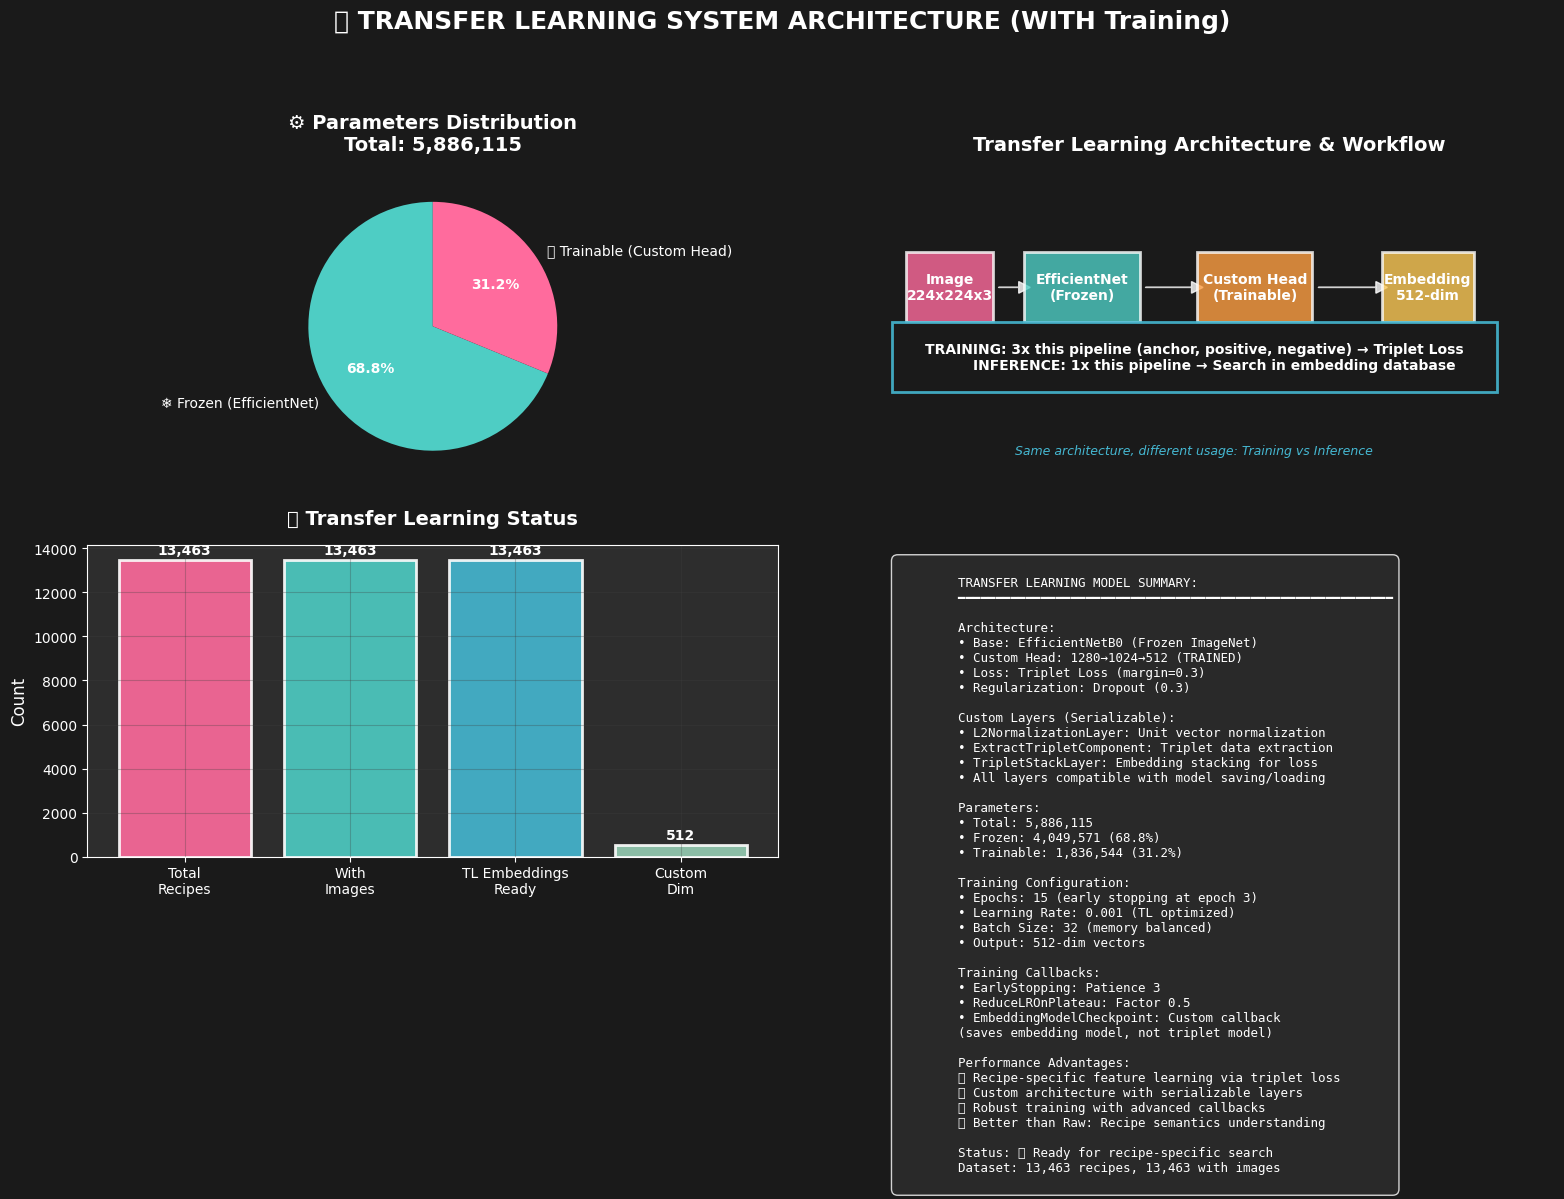


🎯 TRANSFER LEARNING BREAKDOWN:
✅ Frozen EfficientNetB0: 4,049,571 parameters
🔥 Trainable Custom Head: 1,836,544 parameters
📊 Total: 5,886,115 parameters
🎯 Training Ratio: 31.2% trainable
🔥 Custom Head: 1280→1024→512 (TRAINABLE)
🎯 Testing Transfer Learning with: C:\Users\Naturel\.cache\kagglehub\datasets\pes12017000148\food-ingredients-and-recipe-dataset-with-images\versions\1\Food Images\Food Images\double-pecan-thumbprints.jpg
🔍 Searching for 3 similar recipes using Transfer Learning...
✅ Found 3 similar recipes using Transfer Learning


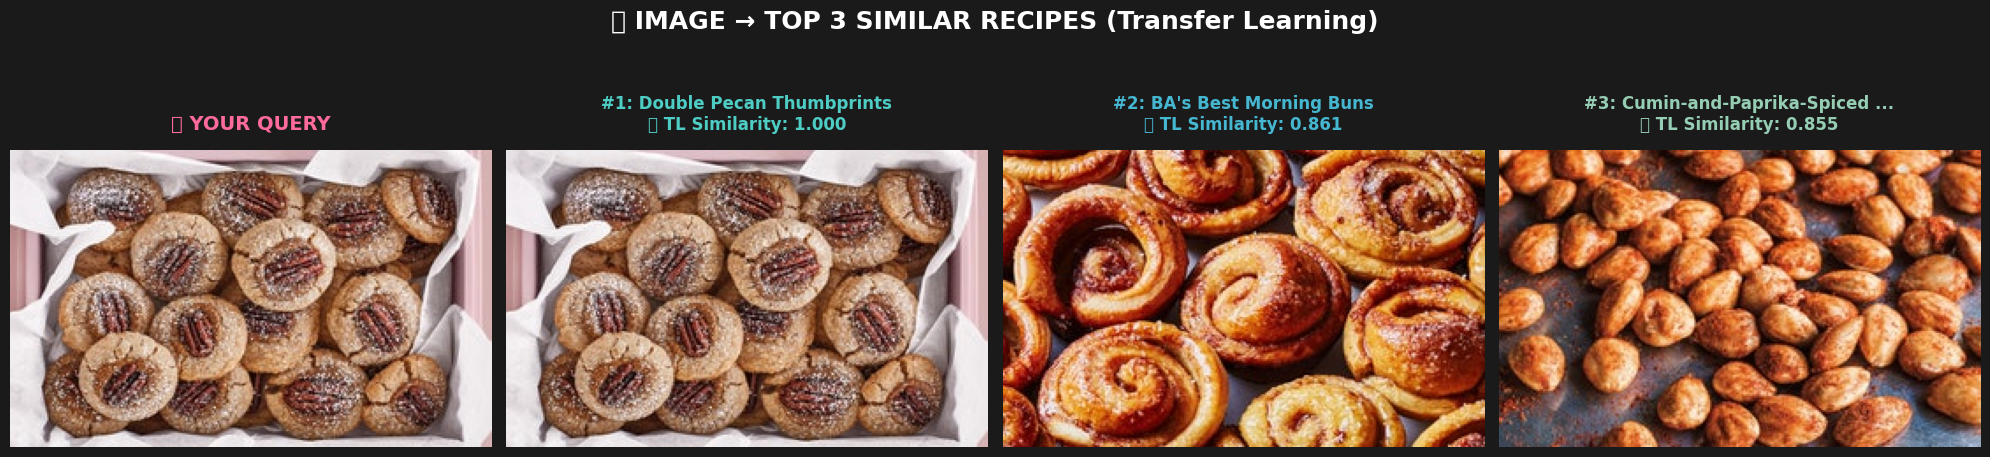


🔥 TOP RECIPE RECOMMENDATIONS (Transfer Learning)

🏆 RANK #1 - TL Similarity: 1.0000
📖 Recipe Title: Double Pecan Thumbprints
------------------------------------------------------------
🥘 Ingredients:
['2 cups pecan halves', '1/3 cup granulated sugar', '1 large egg white', '2 Tbsp. unsalted butter, room temperature', '2 tsp. espresso powder', '1/2 tsp. kosher salt', '1/4 tsp. almond extract', '1 1/4 cups all-purpose flour', '1 tsp. kosher salt', '1/2 tsp. baking powder', '3/4 cup (1 1/2 sticks) u...
------------------------------------------------------------
👨‍🍳 Instructions:
Preheat oven to 350°F. Lightly toast pecans on a rimmed baking sheet, tossing halfway through, until slightly darkened in color and fragrant, 6–8 minutes. Let cool; set 1 1/4 cups pecans aside for making the dough.
Pulse granulated sugar and remaining 3/4 cup pecans in a food processor until nuts are very finely ground (be careful to stop before they become a paste), 30–60 seconds. Add egg white a...

🏆 RANK #2 

In [8]:
# 🧪 TEST WITH RANDOM IMAGE (Auto-load saved system if available) TRANSFER LEARNING
# This will pick a random image and find the top 3 most similar ones
# stand alone script so we need to reload tons of stuff
# good preparation for the deployment

import tensorflow as tf
import pickle
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.layers import Layer

# 🎯 COUCHE L2 NORMALIZATION PERSONNALISÉE (SÉRIALISABLE)
class L2NormalizationLayer(Layer):
    """Couche personnalisée pour normalisation L2 - sérialisable"""
    
    def __init__(self, axis=1, **kwargs):
        super(L2NormalizationLayer, self).__init__(**kwargs)
        self.axis = axis
    
    def call(self, inputs):
        return tf.nn.l2_normalize(inputs, axis=self.axis)
    
    def compute_output_shape(self, input_shape):
        return input_shape
    
    def get_config(self):
        config = super(L2NormalizationLayer, self).get_config()
        config.update({'axis': self.axis})
        return config
    
# 🎯 COUCHE EXTRACTION TRIPLET PERSONNALISÉE (SÉRIALISABLE)
class ExtractTripletComponent(Layer):
    """Couche pour extraire une composante du triplet"""
    
    def __init__(self, component_index, **kwargs):
        super(ExtractTripletComponent, self).__init__(**kwargs)
        self.component_index = component_index
    
    def call(self, inputs):
        return inputs[:, self.component_index]
    
    def compute_output_shape(self, input_shape):
        # input_shape = (batch_size, 3, height, width, channels)
        return (input_shape[0], input_shape[2], input_shape[3], input_shape[4])
    
    def get_config(self):
        config = super(ExtractTripletComponent, self).get_config()
        config.update({'component_index': self.component_index})
        return config

# 🎯 COUCHE STACK TRIPLET PERSONNALISÉE (SÉRIALISABLE)
class TripletStackLayer(Layer):
    """Couche personnalisée pour empiler les embeddings triplet"""
    
    def __init__(self, **kwargs):
        super(TripletStackLayer, self).__init__(**kwargs)
    
    def call(self, inputs):
        # inputs = [anchor_emb, positive_emb, negative_emb]
        return tf.stack(inputs, axis=1)
    
    def compute_output_shape(self, input_shape):
        # input_shape = [(batch_size, embedding_dim), ...]
        batch_size = input_shape[0][0]
        embedding_dim = input_shape[0][1]
        return (batch_size, 3, embedding_dim)
    
    def get_config(self):
        return super(TripletStackLayer, self).get_config()

CONFIG_STANDALONE = {
    'IMG_SIZE': 224,
}

# Try to load saved system
print("🔄 No system in memory, attempting to load saved system...")
    
try:
    # Load embeddings
    embeddings_db = np.load("./tl/recipe_embeddings_database_tl.npy")
    print(f"✅ Embeddings loaded: {embeddings_db.shape}")
    
    # Load metadata
    with open("./tl/recipe_embeddings_database_metadata_tl.pkl", 'rb') as f:
        metadata = pickle.load(f)
    print("✅ Metadata loaded")
    
    # 🆕 Load recipes_with_images DataFrame from saved file
    recipes_df_path = "./data/recipes_with_images_dataframe.pkl"
    if os.path.exists(recipes_df_path):
        recipes_with_images = pd.read_pickle(recipes_df_path)
        print(f"✅ Recipes DataFrame loaded: {len(recipes_with_images)} recipes")
    else:
        print("❌ recipes_with_images_dataframe_tl.pkl not found!")
        print("💡 Please save the DataFrame first using:")
        print("   recipes_with_images.to_pickle('recipes_with_images_dataframe.pkl')")
     
    # Recreate system with loaded DataFrame
    retrieval_system_tl = RecipeImageRetrievalTL()
    retrieval_system_tl.embeddings_db = embeddings_db
    retrieval_system_tl.image_paths = metadata['image_paths']
    retrieval_system_tl.image_to_recipe_map = metadata['image_to_recipe_map']
    
    print(f"🎉 System loaded with {len(embeddings_db):,} embeddings!")
   
except FileNotFoundError as e:
    print(f"❌ File not found: {e}")
    print("💡 Please make sure these files exist:")
    print("   - recipe_image_retrieval_model_tl.keras (or in ./models/ folder)")
    print("   - recipe_embeddings_database_tl.npy")
    print("   - recipe_embeddings_database_metadata_tl.pkl")
    print("   - recipes_with_images_dataframe.pkl")
   
except Exception as e:
    print(f"❌ Error loading system: {e}")
    import traceback
    traceback.print_exc()
    
# Main testing logic
print("\n🎯 Testing with a random image from the database...")
retrieval_system_tl.visualize_model_architecture()
retrieval_system_tl.test_with_random_image(top_k=3)


In [7]:
# 🔍 SEARCH WITH YOUR OWN IMAGE (Auto-load system if needed) TRANSFER LEARNING
# Replace 'your_image_path.jpg' with the path to your image
# Smart system loader (same as testing cell)

import tensorflow as tf
import numpy as np
import os
import pickle
import pandas as pd

# Custom layers pour TL (nécessaires pour le chargement)
class L2NormalizationLayer(tf.keras.layers.Layer):
    def __init__(self, axis=1, **kwargs):
        super(L2NormalizationLayer, self).__init__(**kwargs)
        self.axis = axis
    
    def call(self, inputs):
        # return tf.nn.l2_normalize(inputs, axis=self.axis)
        return tf.nn.l2_normalize(inputs, axis=self.axis)
    
    def get_config(self):
        config = super(L2NormalizationLayer, self).get_config()
        config.update({'axis': self.axis})
        return config

class ExtractTripletComponent(tf.keras.layers.Layer):
    def __init__(self, component_index, **kwargs):
        super(ExtractTripletComponent, self).__init__(**kwargs)
        self.component_index = component_index
    
    def call(self, inputs):
        return inputs[:, self.component_index]
    
    def get_config(self):
        config = super(ExtractTripletComponent, self).get_config()
        config.update({'component_index': self.component_index})
        return config

class TripletStackLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(TripletStackLayer, self).__init__(**kwargs)
    
    def call(self, inputs):
        return tf.stack(inputs, axis=1)
    
    def get_config(self):
        return super(TripletStackLayer, self).get_config()


print("🔄 Loading Transfer Learning retrieval system...")

try:
    
    embeddings_db = np.load("./tl/recipe_embeddings_database_tl.npy")
    
    with open("./tl/recipe_embeddings_database_metadata_tl.pkl", 'rb') as f:
        metadata = pickle.load(f)
    
    # Load recipes DataFrame
    recipes_with_images = pd.read_pickle("./data/recipes_with_images_dataframe.pkl")
    
    # Recreate system
    retrieval_system_tl = RecipeImageRetrievalTL()
    retrieval_system_tl.embeddings_db = embeddings_db
    retrieval_system_tl.image_paths = metadata['image_paths']
    retrieval_system_tl.image_to_recipe_map = metadata['image_to_recipe_map']
    
    print(f"✅ Loaded TL system with {len(embeddings_db):,} embeddings!")
    
except FileNotFoundError:
    print("❌ No saved TL system found. Please build and save first!")
    retrieval_system_tl = None
except Exception as e:
    print(f"❌ Error loading TL system: {e}")
    retrieval_system_tl = None

# Example with your test image
example_image = "./test_recipes/téléchargement.jpg"
    
# Check if the test image exists
if os.path.exists(example_image):
    print(f"🎯 Example - searching with test image (TL): {example_image}")
    
    results = retrieval_system_tl.search_similar_recipes(example_image, top_k=3)
    if results:
        retrieval_system_tl.display_results(example_image, results)
    else:
        print("❌ No results found")
else:
    print(f"⚠️ Test image not found: {example_image}")
    print("💡 Create a test_recipes folder and add some images, or change the path")
    
    # Fallback: use random image from database
    if retrieval_system_tl.image_paths:
        fallback_image = retrieval_system_tl.image_paths[0]
        print(f"🔄 Using fallback image (TL): {fallback_image}")
        
        results = retrieval_system_tl.search_similar_recipes(fallback_image, top_k=3)
        if results:
            retrieval_system_tl.display_results(fallback_image, results)

🔄 Loading Transfer Learning retrieval system...
❌ Error loading TL system: RecipeImageRetrievalTL.__init__() missing 2 required positional arguments: 'model' and 'recipes_df'
🎯 Example - searching with test image (TL): ./test_recipes/téléchargement.jpg


AttributeError: 'NoneType' object has no attribute 'search_similar_recipes'